# COX Proportional Hazards Model for Type 1 diabetes Outcome
>
This notebook contains the code for generating supplementary figures 1 and 2.  

For the main analysis, tri-SNP dosage (0, 1 or 2) is fitted along with covariates: sex, having a first degree relative with T1D diagnosis, genetic ancestry, HLA type, country and SNPS previously associated with the outcome.

The analyses are repeated using only DR3/DQ2 homozygotes.

In addition, the extended haplotype DR3-B8 is fitted instead of tri-SNP as a comparison to show the affect of tri-snp is stronger. 


### Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import CoxPHFitter
import pickle
import warnings
warnings.filterwarnings("ignore")
import session_info

session_info.show(html=False)

-----
lifelines           0.26.3
matplotlib          3.9.4
pandas              1.5.3
session_info        1.0.0
-----
IPython             8.18.1
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.5
-----
Python 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) [Clang 11.1.0 ]
macOS-15.6.1-x86_64-i386-64bit
-----
Session information updated at 2025-09-19 09:45


#### Load metadata

In [2]:
filtered = pd.read_csv("../data/filtered_meta_final.csv")
filtered.head()

,mp257_maskid,family_id,immunochip_id,sex,Cntry,POP,ancestry,POP_reported,t1d,t1d_diag_age_censor,...,rs61751041 (LAMB1),rs6967298 (AUTS2),rs72704176 (ASH1L),rs72717025 (FCGR2A),rs73043122 (RNASET2/MIR3939),rs77532435 (GRB10),rs8013918 (FOS),rs9934817 (RBFOX1),rs389884,rs926552
0,996512,9000247.0,9000247_996512,Male,SWE,EUR,EUR,NaN,1,135.972,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,474979,474979.0,474979_474979,Male,SWE,EUR,EUR,NaN,0,183.443,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,581412,581412.0,581412_581412,Male,SWE,EUR,EUR,NaN,0,186.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,864158,864158.0,864158_864158,Male,SWE,EUR,EUR,EUR,0,167.017,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,669152,669152.0,669152_669152,Male,SWE,EUR,EUR,NaN,0,174.080,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0


#### Create ordered HLA type list
We select the samples from the HLA types passing the filter and create an ordered list for consistency in figures. 

In [3]:
select_hla = ['DR4/DR8', 'DR3/DR3', 'DR3/DR4',
              'DR4/DR4', "DR1/DR4", "DR4/DR13"]
filtered["hla_type"] = pd.Categorical(filtered["hla_type"], 
               categories=select_hla,
               ordered=True)

#### Create oredered population list

In [4]:
select_pops = ["EUR", "AMR", "AFR"]
filtered["POP"] = pd.Categorical(
    filtered["POP"],
    categories=select_pops,
    ordered=True)

#### Create ordered country category

In [5]:
ctry = ["US", "SWE", "FIN", "GER"]
filtered["Country"] = pd.Categorical(
    filtered["Cntry"],
    categories=ctry,
    ordered=True)

#### Load previous GWAS covariates
These SNPs have been shown to be associated with outcomes tested in the paper.

In [6]:
snps = pd.read_table("../data/assoc_snps_220824.tsv")
snps.head()

,SNP,Locus,CD_SNP,tTGA_SNP,T1D_SNP,IAA_SNP,SNP_locus
0,rs4851575,"IL18R1, IL18RAP",1,0,0,0,"rs4851575 (IL18R1, IL18RAP)"
1,rs114569351,"PLEK,FBXO48",1,0,0,0,"rs114569351 (PLEK,FBXO48)"
2,rs12493471,"CCR9,LZTFL1,CXCR6",1,0,0,0,"rs12493471 (CCR9,LZTFL1,CXCR6)"
3,rs1054091,"RSPH3,TAGAP",1,0,0,0,"rs1054091 (RSPH3,TAGAP)"
4,rs72704176,ASH1L,1,0,0,0,rs72704176 (ASH1L)


#### Create lists of SNPs for each outcome

In [7]:
t1d_snps = list(snps.loc[snps["T1D_SNP"] == 1, "SNP_locus"].values)
iaa_snps = list(snps.loc[snps["IAA_SNP"] == 1, "SNP_locus"].values)
tga_snps = list(snps.loc[snps["tTGA_SNP"] == 1, "SNP_locus"].values)
cd_snps = list(snps.loc[snps["CD_SNP"] == 1, "SNP_locus"].values)

## Create coxph model for T1D diagnosis

### Define model parameters
Define covariates, outcome variable, time to event column, etc.

In [8]:
# snps associated with T1D is included in the model
assoc = t1d_snps

# Title for the figure
event = "Event = T1D Diagnosis"

# covariates included in the model
common_variables = ['sex', 'FDR-T1D', 'POP', "hla_type", 
                    "Country"] + assoc

# column names to be used in addition to the fit variable
# for the top panel of the figure
common_others = ["Male", 'FDR-T1D']

# define the column that contains the event time (or censor when sample is censored) 
# and the outcome column, in this case t1d diagnosis.
time, outcome = "t1d_diag_age_censor", "t1d"
outcomes = [time, outcome]

### Fit trisnp for all samples
This will create the supplementary figure 1 as well as the model that will be used partially for main figure 1.

<lifelines.CoxPHFitter: fitted with 7638 total observations, 7243 right-censored observations>
             duration col = 't1d_diag_age_censor'
                event col = 't1d'
          robust variance = True
      baseline estimation = breslow
   number of observations = 7638
number of events observed = 395
   partial log-likelihood = -3281.22
         time fit was run = 2025-09-19 13:45:30 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
tri-SNP 101                    -0.61       0.54       0.14            -0.88            -0.33                 0.41                 0.72
FDR-T1D                         1.13       3.11       0.13             0.89             1.38                 2.42                 3.98
rs73043122 (RNASET2/MIR3939)    0.85       2.35       0.23             0.40             1.31                 1.49                 3.70
rs113306148 (PLEKHA1/MIR3941)   0.73       2.07       0.22             0.30             1.16                 1.35                 3.19
rs428595 (PPIL2)                0.93       2.53       0.12             0.70             1.15                 2.02                 3.17
rs1004446 (INS)                -0.33       0.72       0.08            -0.49            -0.18                 0.61                 0.84
rs2476601 (PTPN22)              0.46       1.59       0.09             0.29             0.64                 1.33                 1.90
rs2292239 (ERBB3)               0.20       1.22       0.07             0.06             0.34                 1.06                 1.41
Male                            0.14       1.16       0.10            -0.05             0.34                 0.95                 1.41
AMR                            -0.14       0.87       0.20            -0.53             0.25                 0.59                 1.28
AFR                            -0.50       0.61       0.74            -1.95             0.95                 0.14                 2.59
DR3/DR3                         0.53       1.70       0.33            -0.11             1.18                 0.89                 3.25
DR3/DR4                         1.16       3.20       0.20             0.78             1.55                 2.18                 4.70
DR4/DR4                         0.23       1.26       0.19            -0.14             0.60                 0.87                 1.81
DR1/DR4                        -0.16       0.85       0.33            -0.80             0.48                 0.45                 1.62
DR4/DR13                        0.15       1.16       0.44            -0.72             1.02                 0.49                 2.78
SWE                            -0.11       0.89       0.13            -0.37             0.14                 0.69                 1.15
FIN                             0.29       1.34       0.14             0.02             0.56                 1.02                 1.75
GER                             0.15       1.16       0.19            -0.23             0.53                 0.79                 1.69

                                  z      p   -log2(p)
covariate                                            
tri-SNP 101                   -4.33 <0.005      16.01
FDR-T1D                        8.94 <0.005      61.21
rs73043122 (RNASET2/MIR3939)   3.67 <0.005      12.02
rs113306148 (PLEKHA1/MIR3941)  3.33 <0.005      10.16
rs428595 (PPIL2)               8.07 <0.005      50.29
rs1004446 (INS)               -4.22 <0.005      15.32
rs2476601 (PTPN22)             5.15 <0.005      21.91
rs2292239 (ERBB3)              2.72   0.01       7.27
Male                           1.43   0.15       2.71
AMR                           -0.71   0.47       1.07
AFR                           -0.67   0.50       1.00
DR3/DR3                        1.61   0.11       3.23
D

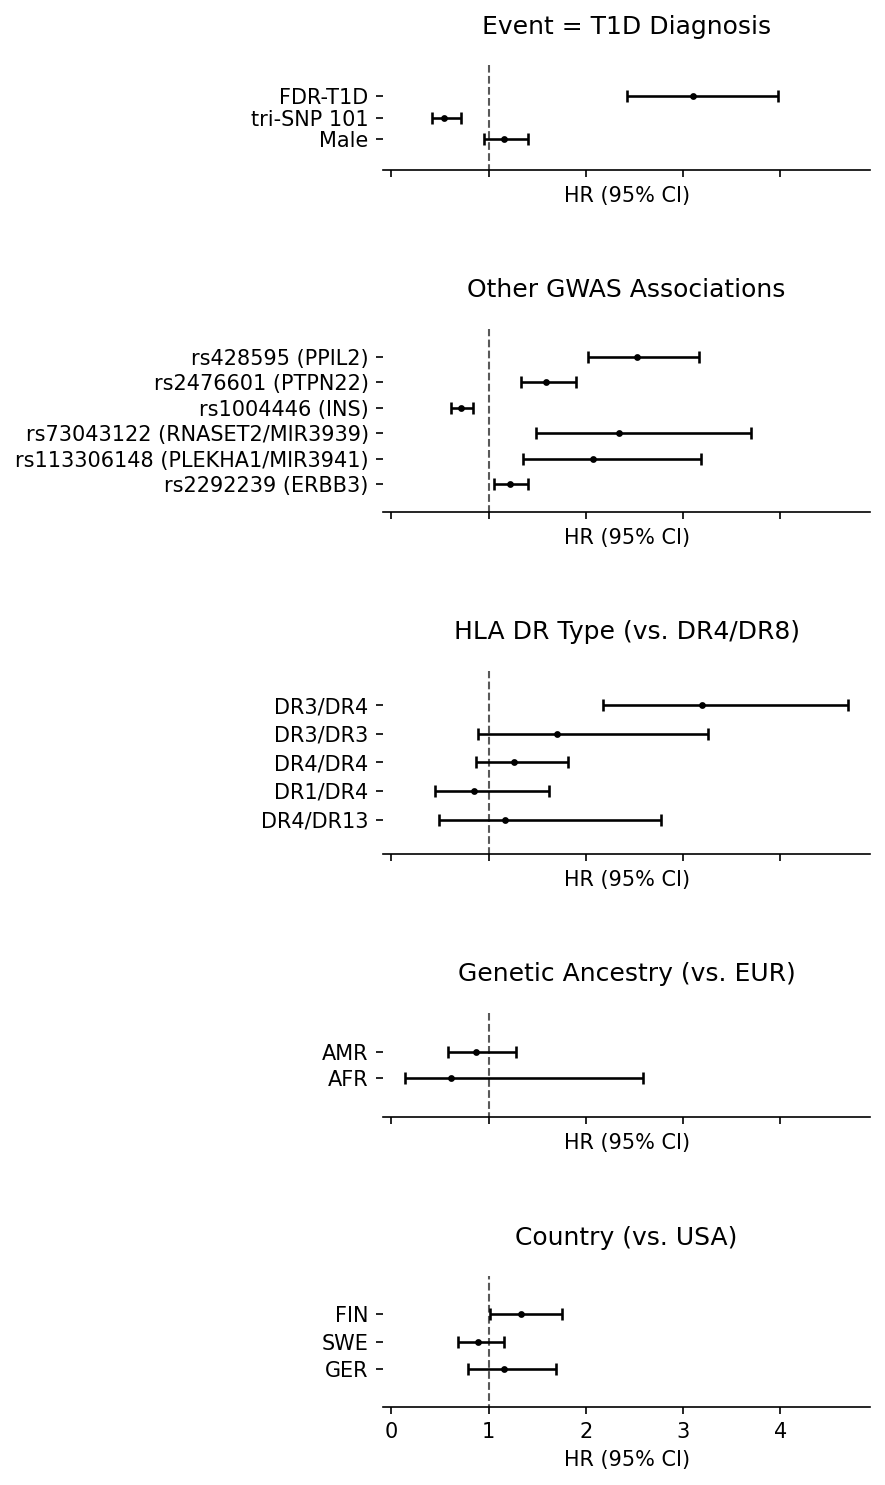

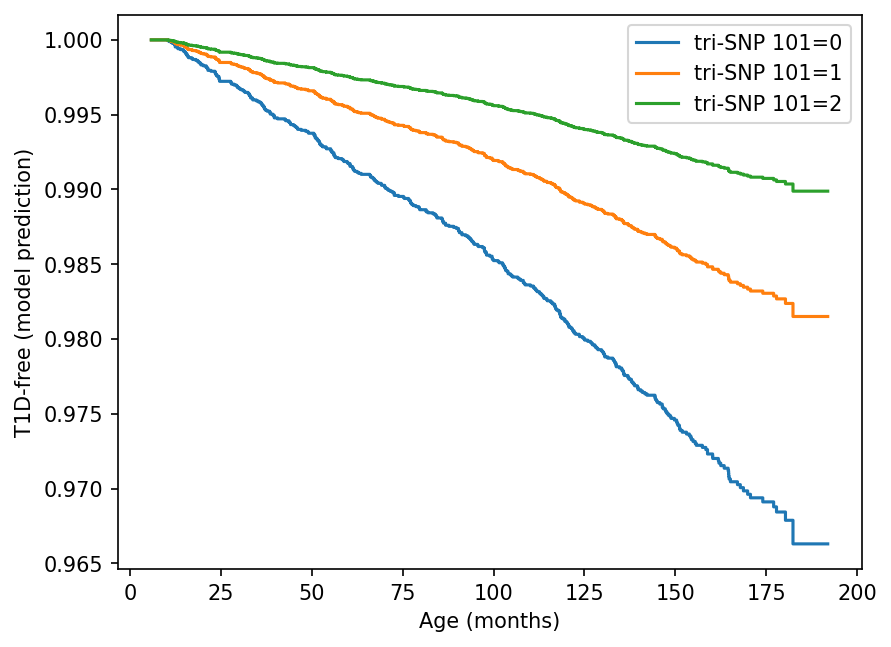

In [9]:
fit_var = "tri-SNP 101"

# stub text to be used in file names
extension = "cox_t1d_all_samples"

# Y axis label for model prediction plot
ylabel = "T1D-free (model prediction)"

# all variables to be included in the model
# That is, the variable to be fitted and other covariates
variables = [fit_var] + common_variables

# limit data to fitted variables and the outcome variables
data = filtered.loc[:, variables + outcomes].dropna()

# Convert categorical variables into dummy/indicator variables
# For example, sex variable has 2 categories: male and female
# dummy variables will have only one column (male)
# which will have 0 for females and 1 for males
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")

# create model object
cph = CoxPHFitter()

# fit the model
cph.fit(dummy, time, event_col=outcome, robust=True)

# print model output summary
cph.print_summary()

# save model summary to file
summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

# Plot model results
# We'll create the plot consisting of subplots for different
# covariate categories. 

others = [fit_var] + common_others 

covar_list = [others, assoc, select_hla, select_pops, ctry]

# create matching subplot titles for the categories
# indicating what the base level was (i.e. vs)
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)

# save figure as pdf and png
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

# create partial effects plot
# this plot will show the model's prediction of how the fitted variable
# would affect the tested outcome in a fashion similar to a survival plot.
fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)

# save figure as pdf and png
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

# save model to use in summary
with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### Fit B8 for all samples
Change the variable fitted from tri-SNP to DR3-B8. This figure is not used in the paper but the model output is used in the text.

<lifelines.CoxPHFitter: fitted with 7638 total observations, 7243 right-censored observations>
             duration col = 't1d_diag_age_censor'
                event col = 't1d'
          robust variance = True
      baseline estimation = breslow
   number of observations = 7638
number of events observed = 395
   partial log-likelihood = -3281.58
         time fit was run = 2025-09-19 13:45:34 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
B8                             -0.44       0.64       0.11            -0.66            -0.22                 0.52                 0.80
FDR-T1D                         1.13       3.10       0.13             0.88             1.38                 2.42                 3.98
rs73043122 (RNASET2/MIR3939)    0.86       2.36       0.23             0.40             1.32                 1.50                 3.73
rs113306148 (PLEKHA1/MIR3941)   0.76       2.14       0.22             0.33             1.18                 1.40                 3.26
rs428595 (PPIL2)                0.94       2.57       0.12             0.71             1.17                 2.04                 3.23
rs1004446 (INS)                -0.34       0.71       0.08            -0.49            -0.18                 0.61                 0.83
rs2476601 (PTPN22)              0.46       1.59       0.09             0.29             0.64                 1.33                 1.90
rs2292239 (ERBB3)               0.20       1.22       0.07             0.05             0.34                 1.06                 1.40
Male                            0.14       1.15       0.10            -0.06             0.34                 0.94                 1.40
AMR                            -0.11       0.90       0.20            -0.50             0.29                 0.61                 1.33
AFR                            -0.27       0.76       0.73            -1.70             1.16                 0.18                 3.19
DR3/DR3                         0.03       1.03       0.26            -0.48             0.54                 0.62                 1.71
DR3/DR4                         0.91       2.48       0.17             0.57             1.24                 1.77                 3.46
DR4/DR4                         0.22       1.25       0.19            -0.14             0.59                 0.87                 1.80
DR1/DR4                        -0.16       0.85       0.33            -0.80             0.48                 0.45                 1.62
DR4/DR13                        0.14       1.16       0.44            -0.73             1.01                 0.48                 2.76
SWE                            -0.12       0.89       0.13            -0.37             0.14                 0.69                 1.15
FIN                             0.27       1.31       0.14            -0.00             0.54                 1.00                 1.71
GER                             0.16       1.17       0.19            -0.22             0.54                 0.80                 1.71

                                  z      p   -log2(p)
covariate                                            
B8                            -3.92 <0.005      13.49
FDR-T1D                        8.95 <0.005      61.30
rs73043122 (RNASET2/MIR3939)   3.69 <0.005      12.13
rs113306148 (PLEKHA1/MIR3941)  3.51 <0.005      11.11
rs428595 (PPIL2)               8.10 <0.005      50.73
rs1004446 (INS)               -4.28 <0.005      15.69
rs2476601 (PTPN22)             5.16 <0.005      21.95
rs2292239 (ERBB3)              2.70   0.01       7.16
Male                           1.36   0.17       2.52
AMR                           -0.53   0.60       0.74
AFR                           -0.37   0.71       0.49
DR3/DR3                        0.11   0.91       0.13
D

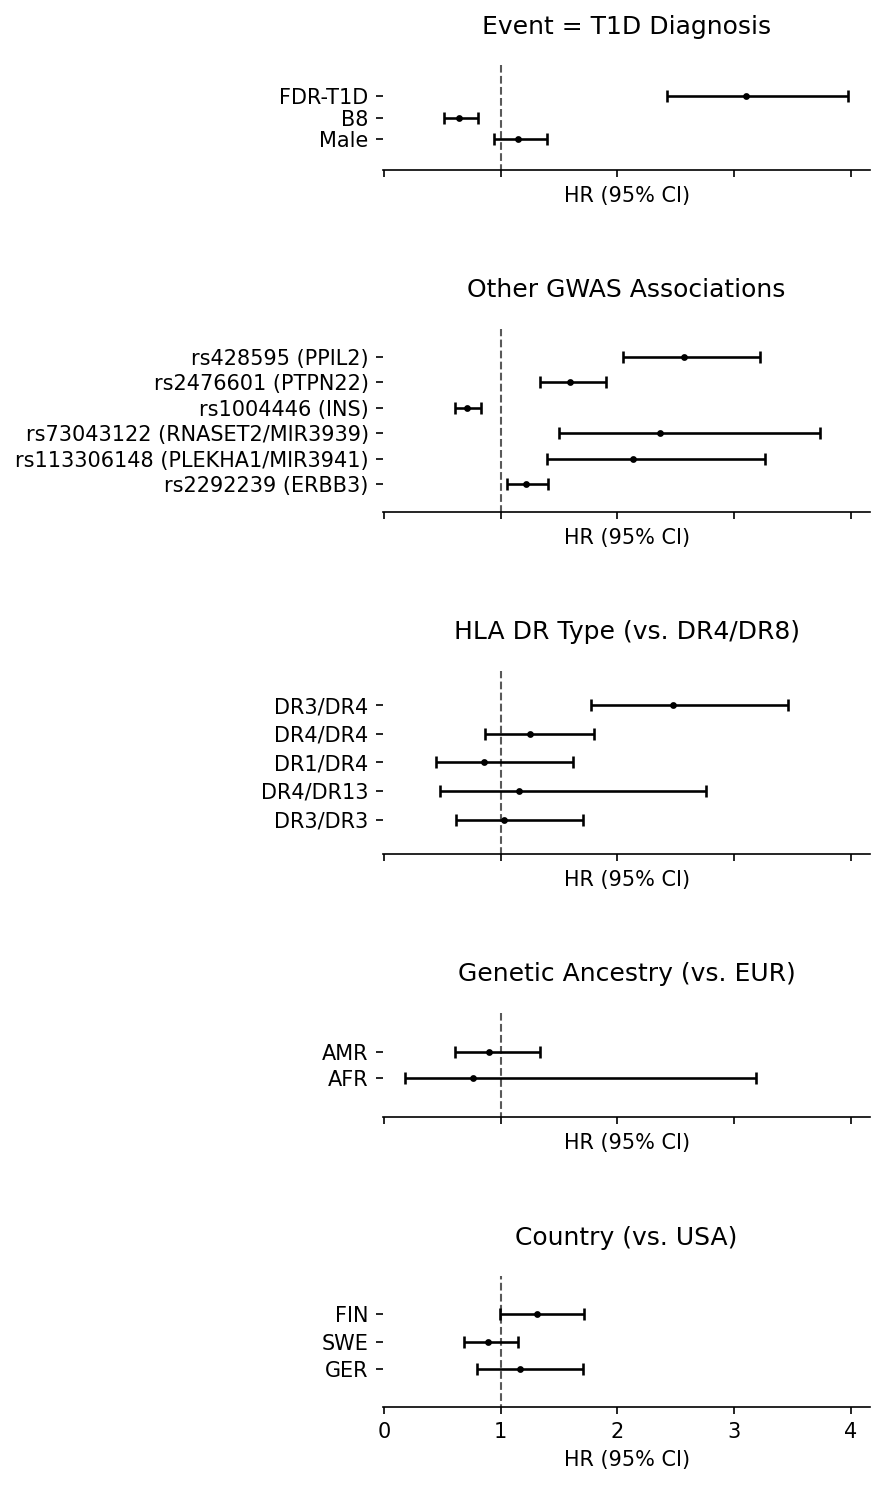

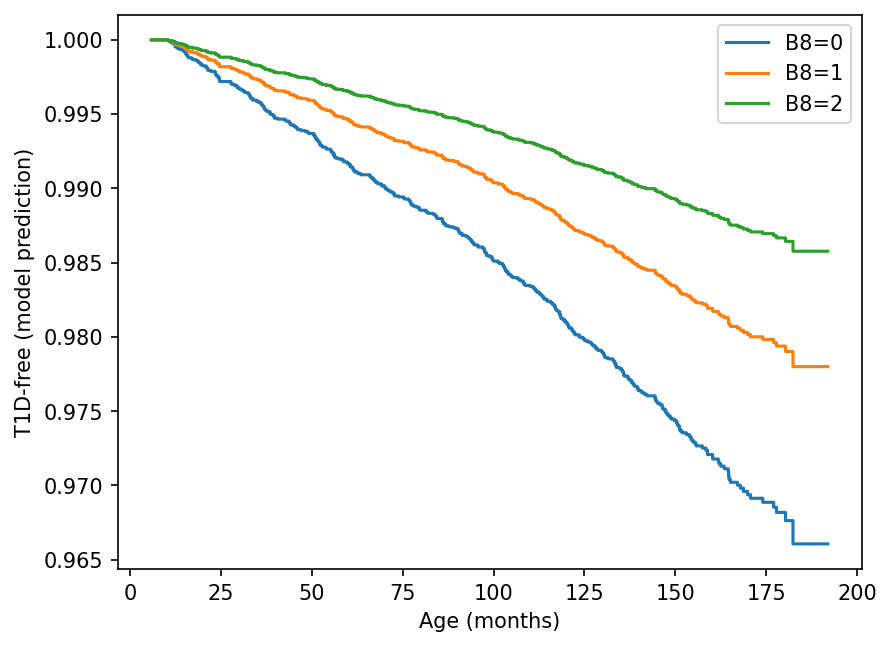

In [10]:
fit_var = "B8"

# stub text to be used in file names
extension = "cox_t1d_all_samples_b8"

# Y axis label for model prediction plot
ylabel = "T1D-free (model prediction)"

# all variables to be included in the model
# That is, the variable to be fitted and other covariates
variables = [fit_var] + common_variables

# limit data to fitted variables and the outcome variables
data = filtered.loc[:, variables + outcomes].dropna()

# Convert categorical variables into dummy/indicator variables
# For example, sex variable has 2 categories: male and female
# dummy variables will have only one column (male)
# which will have 0 for females and 1 for males
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")

# create model object
cph = CoxPHFitter()

# fit the model
cph.fit(dummy, time, event_col=outcome, robust=True)

# print model output summary
cph.print_summary()

# save model summary to file
summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

# Plot model results
others = [fit_var] + common_others

covar_list = [others, assoc, select_hla, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

# create partial effects plot
fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

# save model to disk
with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### DR3 homozygotes only
Same analysis as above but limiting to DR3/DR3 homozygote individuals only.

In [11]:
event = "Event = T1D Diagnosis, DR3 Only"

# we remove the hla_type from the covariates here because
# all samples are from the same hla type. 
common_variables = ['sex', 'FDR-T1D', 'POP', 
                    "Country"] + assoc

### Fit trisnp
This will create the supplementary figure 2.

<lifelines.CoxPHFitter: fitted with 1589 total observations, 1553 right-censored observations>
             duration col = 't1d_diag_age_censor'
                event col = 't1d'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1589
number of events observed = 36
   partial log-likelihood = -235.90
         time fit was run = 2025-09-19 13:45:39 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
tri-SNP 101                    -1.05       0.35       0.24            -1.51            -0.58                 0.22                 0.56
FDR-T1D                         1.05       2.86       0.43             0.20             1.90                 1.22                 6.67
rs73043122 (RNASET2/MIR3939)    0.34       1.40       1.00            -1.62             2.30                 0.20                 9.99
rs113306148 (PLEKHA1/MIR3941)   0.76       2.13       0.73            -0.68             2.19                 0.51                 8.98
rs428595 (PPIL2)                0.28       1.32       0.87            -1.42             1.98                 0.24                 7.27
rs1004446 (INS)                -0.54       0.59       0.28            -1.08             0.01                 0.34                 1.01
rs2476601 (PTPN22)              0.92       2.51       0.30             0.32             1.52                 1.38                 4.56
rs2292239 (ERBB3)               0.25       1.28       0.26            -0.27             0.77                 0.76                 2.15
Male                            0.04       1.04       0.35            -0.66             0.73                 0.52                 2.07
AMR                            -0.86       0.42       0.99            -2.79             1.08                 0.06                 2.93
AFR                            -0.32       0.72       1.18            -2.63             1.98                 0.07                 7.25
SWE                             0.20       1.23       0.40            -0.58             0.99                 0.56                 2.70
FIN                             0.25       1.28       0.53            -0.78             1.28                 0.46                 3.60
GER                             0.30       1.35       0.63            -0.94             1.54                 0.39                 4.67

                                  z      p   -log2(p)
covariate                                            
tri-SNP 101                   -4.40 <0.005      16.52
FDR-T1D                        2.43   0.02       6.05
rs73043122 (RNASET2/MIR3939)   0.34   0.73       0.44
rs113306148 (PLEKHA1/MIR3941)  1.03   0.30       1.73
rs428595 (PPIL2)               0.32   0.75       0.42
rs1004446 (INS)               -1.91   0.06       4.17
rs2476601 (PTPN22)             3.02 <0.005       8.63
rs2292239 (ERBB3)              0.94   0.35       1.52
Male                           0.10   0.92       0.12
AMR                           -0.87   0.38       1.38
AFR                           -0.28   0.78       0.35
SWE                            0.51   0.61       0.71
FIN                            0.48   0.63       0.66
GER                            0.47   0.64       0.65
---
Concordance = 0.76
Partial AIC = 499.79
log-likelihood ratio test = 34.05 on 14 df
-log2(p) of ll-ratio test = 8.95

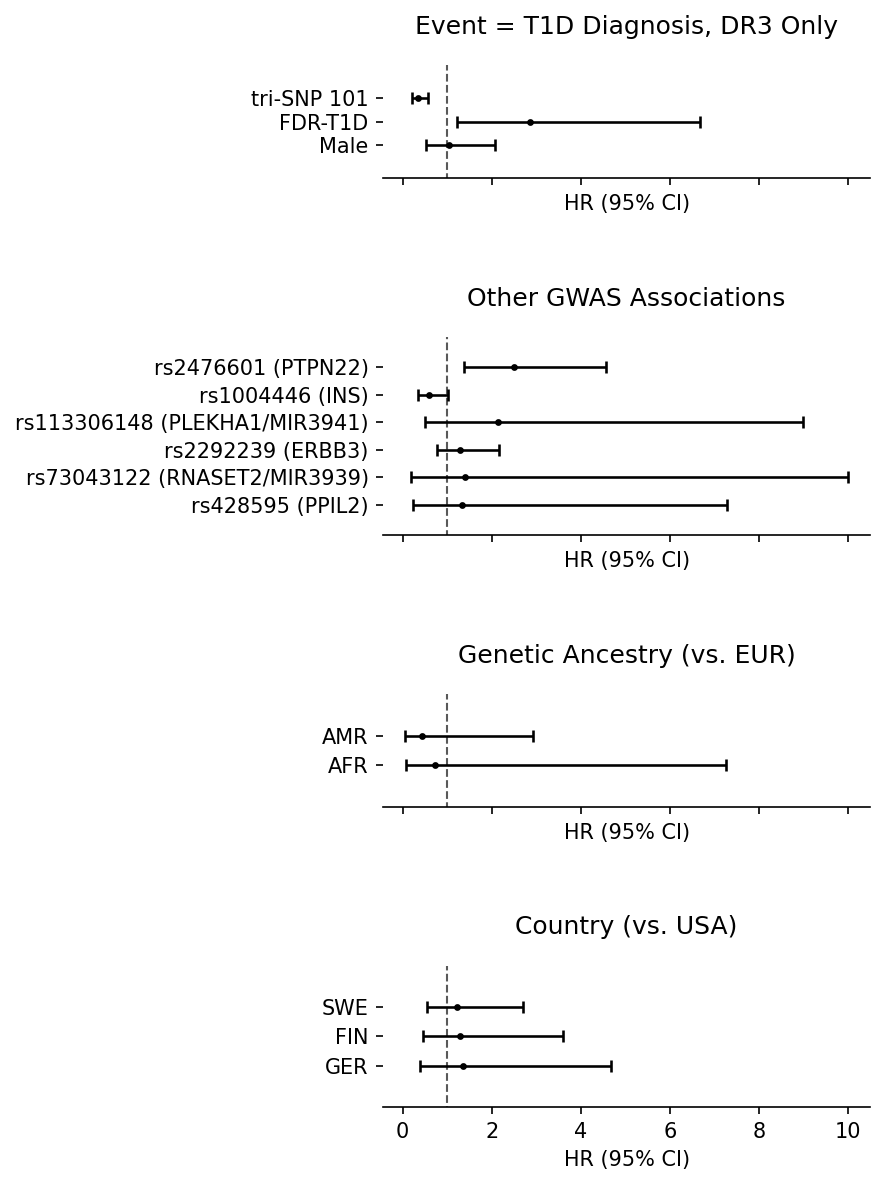

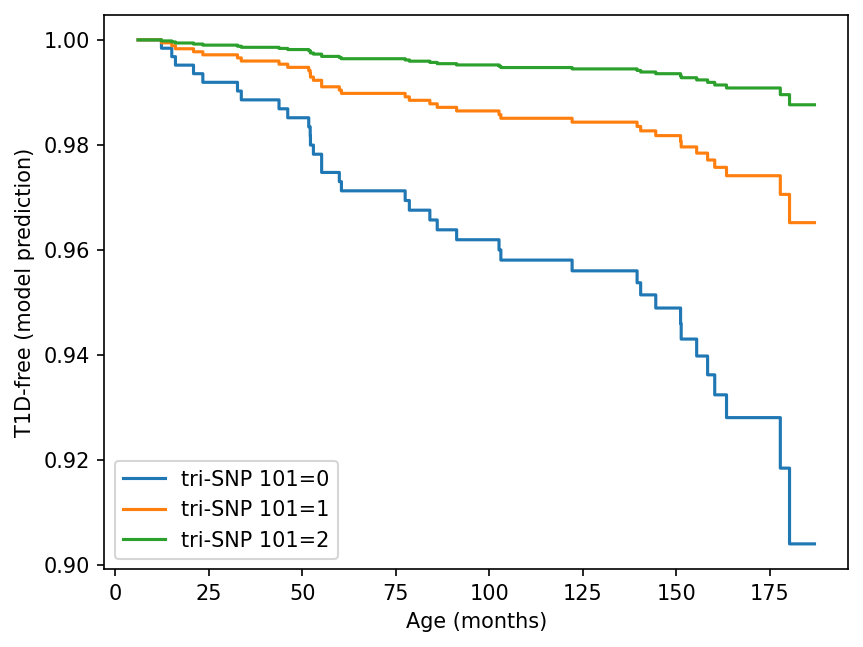

In [12]:
fit_var = "tri-SNP 101"

extension = "cox_t1d_dr3_samples"
ylabel = "T1D-free (model prediction)"

variables = [fit_var] + common_variables

data = filtered.loc[filtered["hla_type"] == "DR3/DR3",
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### Fit B8 for DR3 homozygotes only

<lifelines.CoxPHFitter: fitted with 1589 total observations, 1553 right-censored observations>
             duration col = 't1d_diag_age_censor'
                event col = 't1d'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1589
number of events observed = 36
   partial log-likelihood = -237.56
         time fit was run = 2025-09-19 13:45:41 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
B8                             -0.73       0.48       0.21            -1.13            -0.32                 0.32                 0.73
FDR-T1D                         1.08       2.94       0.44             0.22             1.93                 1.25                 6.92
rs73043122 (RNASET2/MIR3939)    0.51       1.67       0.99            -1.43             2.46                 0.24                11.67
rs113306148 (PLEKHA1/MIR3941)   0.79       2.20       0.72            -0.63             2.21                 0.53                 9.07
rs428595 (PPIL2)                0.05       1.06       0.90            -1.70             1.81                 0.18                 6.10
rs1004446 (INS)                -0.53       0.59       0.29            -1.09             0.04                 0.34                 1.04
rs2476601 (PTPN22)              0.90       2.46       0.32             0.28             1.52                 1.32                 4.59
rs2292239 (ERBB3)               0.24       1.27       0.26            -0.26             0.74                 0.77                 2.10
Male                            0.05       1.05       0.34            -0.62             0.73                 0.54                 2.07
AMR                            -0.42       0.66       1.00            -2.39             1.54                 0.09                 4.68
AFR                             0.42       1.52       1.07            -1.67             2.51                 0.19                12.33
SWE                             0.19       1.21       0.40            -0.59             0.97                 0.55                 2.63
FIN                             0.11       1.12       0.52            -0.90             1.13                 0.41                 3.09
GER                             0.30       1.35       0.64            -0.95             1.54                 0.39                 4.68

                                  z      p   -log2(p)
covariate                                            
B8                            -3.51 <0.005      11.12
FDR-T1D                        2.46   0.01       6.17
rs73043122 (RNASET2/MIR3939)   0.52   0.61       0.72
rs113306148 (PLEKHA1/MIR3941)  1.09   0.28       1.85
rs428595 (PPIL2)               0.06   0.95       0.07
rs1004446 (INS)               -1.84   0.07       3.92
rs2476601 (PTPN22)             2.83 <0.005       7.76
rs2292239 (ERBB3)              0.93   0.35       1.50
Male                           0.15   0.88       0.19
AMR                           -0.42   0.67       0.57
AFR                            0.40   0.69       0.53
SWE                            0.47   0.64       0.65
FIN                            0.22   0.82       0.28
GER                            0.47   0.64       0.64
---
Concordance = 0.75
Partial AIC = 503.13
log-likelihood ratio test = 30.72 on 14 df
-log2(p) of ll-ratio test = 7.36

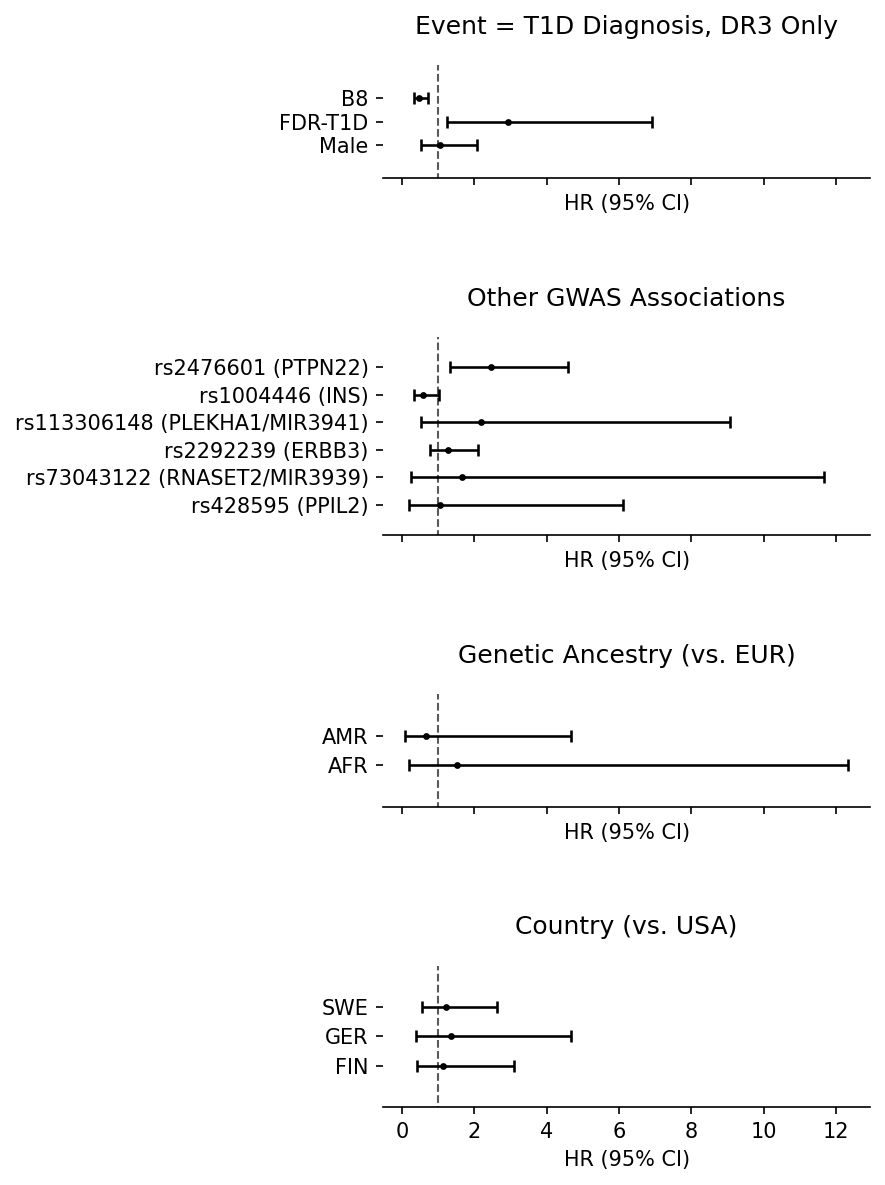

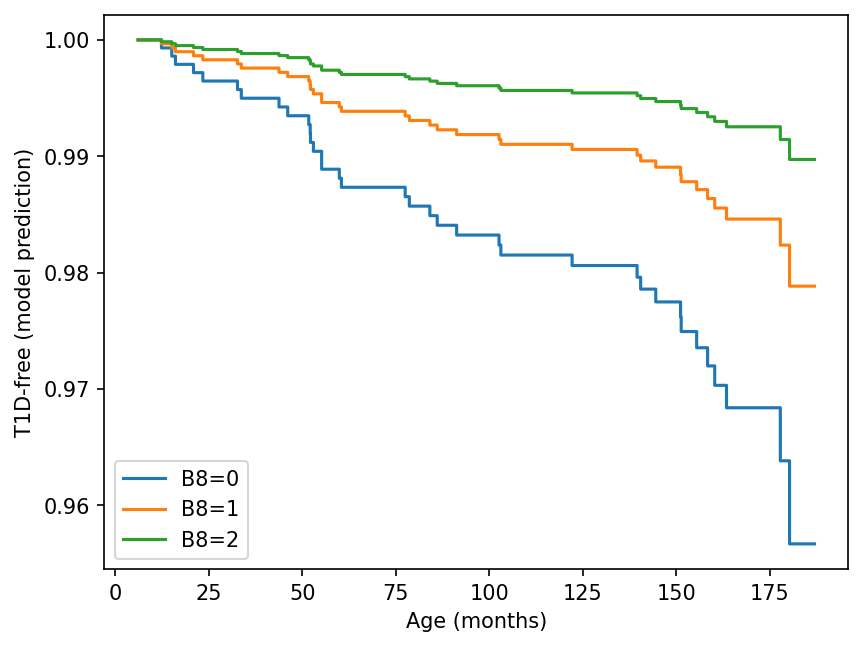

In [13]:
fit_var = "B8"

extension = "cox_t1d_dr3_samples_b8"
ylabel = "T1D-free (model prediction)"

variables = [fit_var] + common_variables

data = filtered.loc[filtered["hla_type"] == "DR3/DR3",
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)